In this notebook we consider a simple 1d global optimization task accelerated by the Tensor Train (TT).

First, one needs to build an encoder, that maps bit strings (indices of a TT) into values in the
interval (0, 2) where we are going to search for a maximum modulo value of a function.

We also need a TT representation of this encoder. Although, it is easy to build TT representation of this encoder
analytically, we will use the TTCross algorithm for simplicity.

In [1]:
import numpy as np
from ttrs import TTVc64

# It is a number of TT modes (indices)
MODES_NUM = 40

# this is the encoder function, it converts a bit-string (index of a TT) into a value
# from the interval (0, 2)
def index2value(index):
    if index is None:
        return None
    else:
        weights = 1 / (2 ** np.arange(0, MODES_NUM))
        return np.array(np.tensordot(index, weights, axes=1), dtype=np.complex128)

# here we build TT representation of this function (we know that its rank is 2
# and therefor set maxrank = 2)
tt_index2value = TTVc64(MODES_NUM * [2], 2, 0.01)

# in this loop we iterate TTCross algorithm;
# note, that in order the result be meaningful
# number of iterations should be MODES_NUM * N
# where N is some integer
for _ in range(MODES_NUM * 4):
    index = tt_index2value.get_args()
    if index is None:
        tt_index2value.update(None)
    else:
        val = index2value(index)
        tt_index2value.update(val)

Now let us choose a function, that is inconvenient for optimization.
In the cell below, we defined and plotted this function.
The maximum modulo is achieved for x = 1.23456789, but this value corresponds
to a very high peak that usually is difficult to detect.

Text(0.5, 0, 'x')

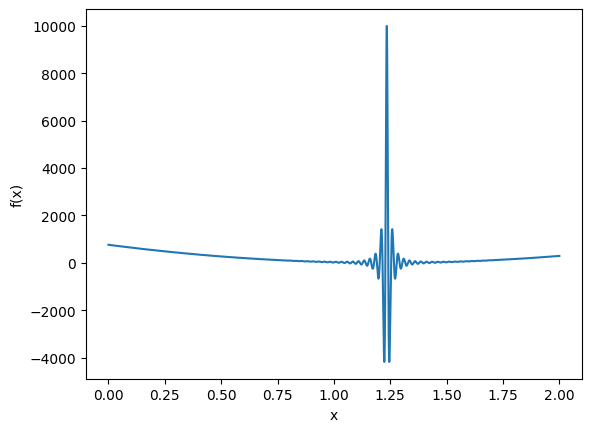

In [2]:
import matplotlib.pyplot as plt

# now let us define a function that we will be studying
def weird_function(x):
    return np.cos(250 * (x - 1.23456789)) / ((x - 1.23456789) ** 2 + 0.0001) + 500 * (x - 1.23456789) ** 2

x = np.linspace(0, 2, 100000)

plt.plot(x, weird_function(x))
plt.ylabel("f(x)")
plt.xlabel("x")


Let us reconstruct the TT representation of this function. For this purpose we run TTCross
with the following parameters: maxrank = 30, number of DMRG sweep = 6. After this, we set the corresponding TT into
the left-canonical form and truncate it with accuracy 1e-9.

In [3]:
tt_weird_function = TTVc64(MODES_NUM * [2], 30, 0.01)

for _ in range(MODES_NUM * 6):
    index = tt_weird_function.get_args()
    if index is None:
        tt_weird_function.update(None)
    else:
        val = weird_function(index2value(index))
        tt_weird_function.update(val)

tt_weird_function.set_into_left_canonical()
tt_weird_function.truncate_left_canonical(1e-9)
print("Bond dimensions:", tt_weird_function.get_bonds())

Bond dimensions: [2, 4, 8, 13, 14, 13, 11, 10, 9, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]


To find a maximum modulo element we run power iteration, i.e. multiply TT representation of this
function many times by itself. After each iteration we set it into the left canonical form and truncate
it with accuracy 1e-9 in order to prevent rank explosion. Note, that setting into the left canonical form routine also
normalizes a TT by 1.

In [4]:
clone_tt_weird_function = tt_weird_function.get_clone()
for _ in range(1000):
    tt_weird_function.elementwise_prod(clone_tt_weird_function)
    tt_weird_function.set_into_left_canonical()
    tt_weird_function.truncate_left_canonical(1e-9)

After 1000 power iterations, only close to maximum modulo elements have survived. Let us find the average argument of these elements. It can be done as follows. We take an element wise square of the TT obtained by the power iteration, that is a probability distribution, since the TT is normalized by 1, and then we average argument over this probability distribution simply taking the dot product between the obtained TT after the power iteration and the TT representation of the encoder function.

Found argmax:  1.23456789006637
Genuine argmax:  1.23456789


/home/ilia-luchnikov/Documents/ttrs/venv/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


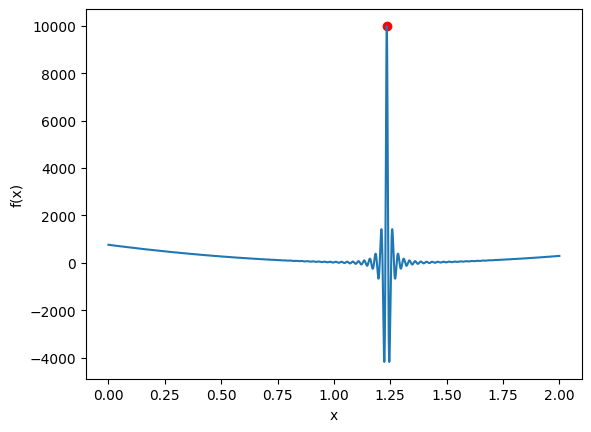

In [5]:
clone_tt_weird_function = tt_weird_function.get_clone()

# now tt_weird_function is a probability distribution
tt_weird_function.elementwise_prod(clone_tt_weird_function)

# here we calculate the average argmax
argmax = np.exp(tt_weird_function.log_dot(tt_index2value))

# and this is the corresponding max value
max = weird_function(argmax)

# And here we print the result, and plot the max point in red

print("Found argmax: ", argmax.real)
print("Genuine argmax: ", 1.23456789)

x = np.linspace(0, 2, 100000)
plt.plot(x, weird_function(x))
plt.ylabel("f(x)")
plt.xlabel("x")
plt.scatter(argmax, max, color='r')